<a href="https://colab.research.google.com/github/sampriti-mahapatra/customer-churn-prediction/blob/main/Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing data from Kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sampritimahapatra","key":"61216ffdc0cf23887c6cd5c162dbe774"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d blastchar/telco-customer-churn

Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
telco-customer-churn.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip telco-customer-churn.zip -d telco_data

Archive:  telco-customer-churn.zip
replace telco_data/WA_Fn-UseC_-Telco-Customer-Churn.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no


In [5]:
import os
os.listdir("telco_data")

['WA_Fn-UseC_-Telco-Customer-Churn.csv']

In [6]:
import pandas as pd
import warnings
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

In [7]:
df = pd.read_csv("telco_data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
print(df.info())  # Displays column data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [9]:
# Check for Duplicates
print(f"Duplicate rows: {df.duplicated().sum()}")

Duplicate rows: 0


In [10]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce") # changing the values in TotalCharges to float type

### Balancing Numerical Columns and Handling Outliers

In [11]:
numerical_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

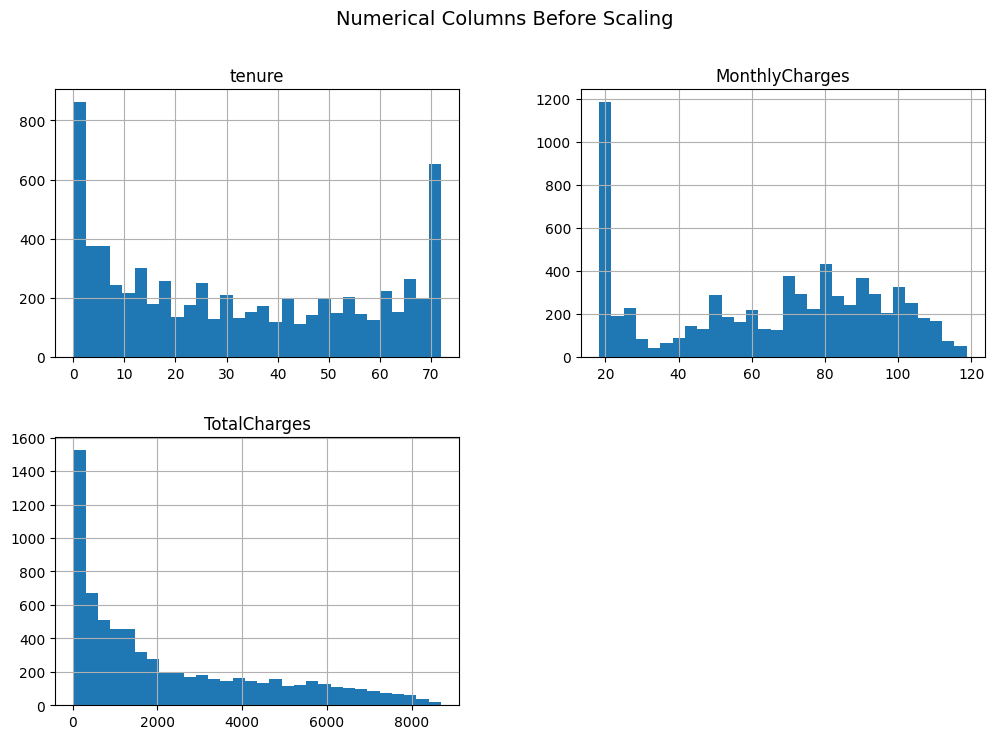

In [12]:
df[numerical_cols].hist(figsize=(12, 8), bins=30)
plt.suptitle("Numerical Columns Before Scaling", fontsize=14)
plt.show()

In [13]:
skewness_values = df[numerical_cols].skew()

# Display skewness
print("Skewness of Numerical Features:")
print(skewness_values)

Skewness of Numerical Features:
tenure            0.239540
MonthlyCharges   -0.220524
TotalCharges      0.961642
dtype: float64


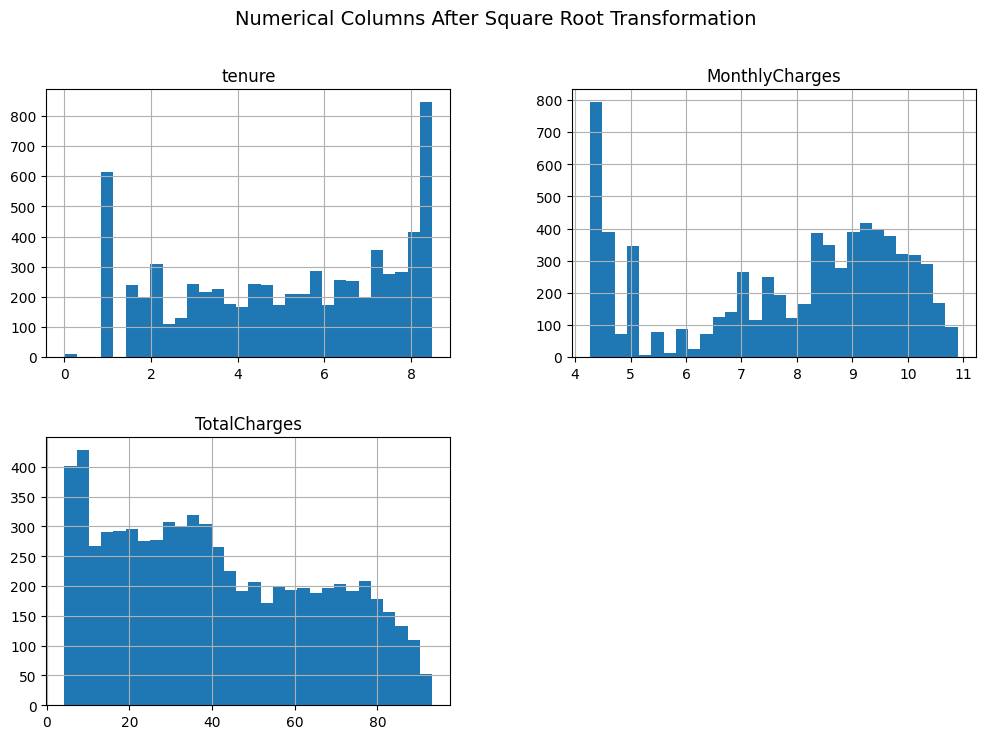

In [14]:
df["tenure"] = np.sqrt(df["tenure"])
df["MonthlyCharges"] = np.sqrt(df["MonthlyCharges"])
df["TotalCharges"] = np.sqrt(df["TotalCharges"])
df[numerical_cols].hist(figsize=(12, 8), bins=30)
plt.suptitle("Numerical Columns After Square Root Transformation", fontsize=14)
plt.show()

In [15]:
Q1 = df[numerical_cols].quantile(0.25)  # First quartile (25th percentile)
Q3 = df[numerical_cols].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile range

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = ((df[numerical_cols] < lower_bound) | (df[numerical_cols] > upper_bound)).sum()
print("Number of outliers in each column:\n", outliers)


Number of outliers in each column:
 tenure            0
MonthlyCharges    0
TotalCharges      0
dtype: int64


In [16]:
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

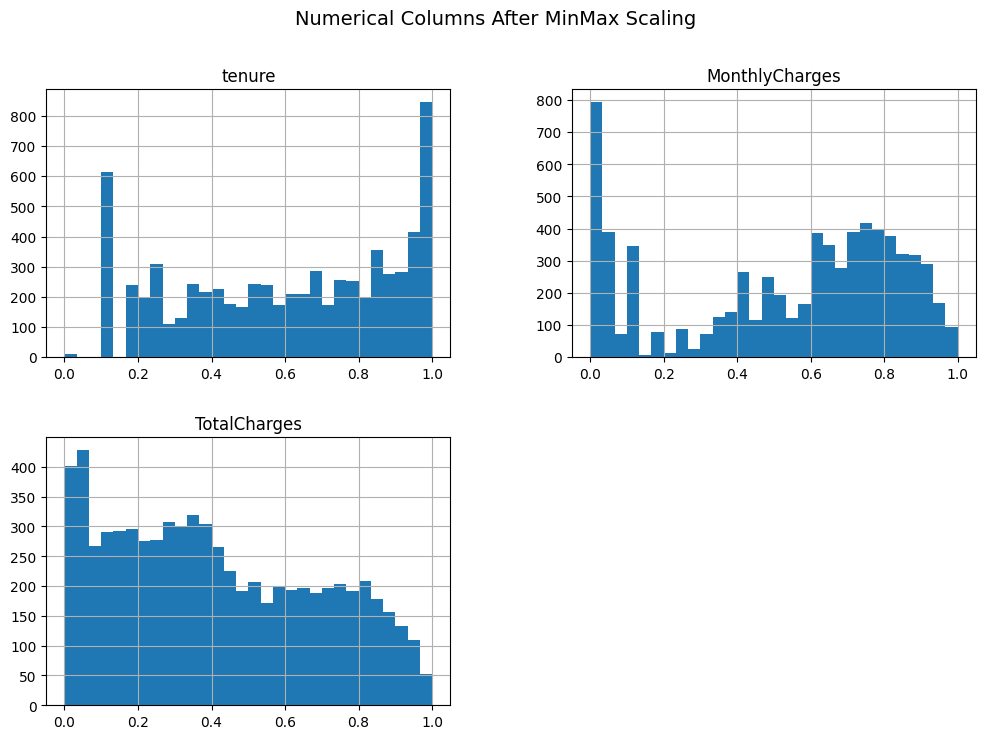

In [17]:
df[numerical_cols].hist(figsize=(12, 8), bins=30)
plt.suptitle("Numerical Columns After MinMax Scaling", fontsize=14)
plt.show()

In [18]:
skewness_values = df[numerical_cols].skew()

# Display skewness
print("Skewness of Numerical Features:")
print(skewness_values)

Skewness of Numerical Features:
tenure           -0.235999
MonthlyCharges   -0.484557
TotalCharges      0.308926
dtype: float64


In [19]:
df[numerical_cols].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,0.602761,0.529668,0.412635
std,0.293752,0.309899,0.276194
min,0.000000,0.000000,0.000000
25%,0.353553,0.254509,0.176693
50%,0.634648,0.621183,0.371914
75%,0.874007,0.785921,0.644473
max,1.000000,1.000000,1.000000


In [20]:
# Combining StreamingTV and StreamingMovies Columns under Streaming

def categorize_streaming(row):
    if row["StreamingTV"] == "Yes" and row["StreamingMovies"] == "Yes":
        return "Both"
    elif row["StreamingTV"] == "Yes" and row["StreamingMovies"] == "No":
        return "TV Only"
    elif row["StreamingMovies"] == "Yes" and row["StreamingTV"] == "No":
        return "Movies Only"
    else:
        return"None"

df["Streaming"] = df.apply(categorize_streaming, axis=1)
print(df["Streaming"].value_counts())

Streaming
None           3544
Both           1940
Movies Only     792
TV Only         767
Name: count, dtype: int64


In [21]:
# Drop the old columns
df = df.drop(columns=["StreamingTV", "StreamingMovies"])

In [22]:
def categorize_support(row):
    if row["DeviceProtection"] == "Yes" and row["TechSupport"] == "Yes":
        return "Both"
    elif row["DeviceProtection"] == "Yes" and row["TechSupport"] == "No":
        return "Device Protection Only"
    elif row["DeviceProtection"] == "No" and row["TechSupport"] == "Yes":
        return "Tech Support Only"
    else:
        return "None"


# Apply function to create new column
df["Support"] = df.apply(categorize_support, axis=1)
print(df["Support"].value_counts())

Support
None                      3786
Device Protection Only    1213
Both                      1209
Tech Support Only          835
Name: count, dtype: int64


In [23]:
# Drop original columns
df = df.drop(columns=["DeviceProtection", "TechSupport"])

In [24]:
def categorize_security_backup(row):
    if row["OnlineSecurity"] == "Yes" and row["OnlineBackup"] == "Yes":
        return "Both"
    elif row["OnlineSecurity"] == "Yes" and row["OnlineBackup"] == "No":
        return "Online Security Only"
    elif row["OnlineSecurity"] == "No" and row["OnlineBackup"] == "Yes":
        return "Online Backup Only"
    else:
        return "None"

# Apply function to create new column
df["Security-Backup"] = df.apply(categorize_security_backup, axis=1)
print(df["Security-Backup"].value_counts())  # Check category distribution

Security-Backup
None                    3721
Online Backup Only      1303
Both                    1126
Online Security Only     893
Name: count, dtype: int64


In [25]:
df = df.drop(columns=["OnlineSecurity", "OnlineBackup"])

In [26]:
def categorize_family(row):
    if row["Partner"] == "No" and row["Dependents"] == "No":
        return "Single, No Kids"
    elif row["Partner"] == "No" and row["Dependents"] != "No":
        return "Single Parent"
    elif row["Partner"] == "Yes" and row["Dependents"] == "No":
        return "Couple, No Kids"
    elif row["Partner"] == "Yes" and row["Dependents"] != "No":
        return "Couple with Kids"
    return "Unknown"

# Apply function to create new column
df["Family_Status"] = df.apply(categorize_family, axis=1)

# Verify the change
print(df["Family_Status"].value_counts())

Family_Status
Single, No Kids     3280
Couple with Kids    1749
Couple, No Kids     1653
Single Parent        361
Name: count, dtype: int64


In [27]:
# Drop original columns
df = df.drop(columns=["Partner", "Dependents"])

### Exploratory Data Analysis

Churn
No     5174
Yes    1869
Name: count, dtype: int64


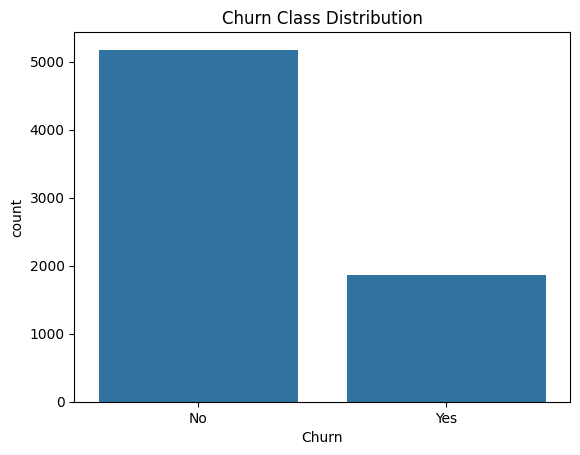

In [28]:
# Check class distribution
print(df["Churn"].value_counts())

# Visualize class distribution
sns.countplot(x=df["Churn"])
plt.title("Churn Class Distribution")
plt.show()


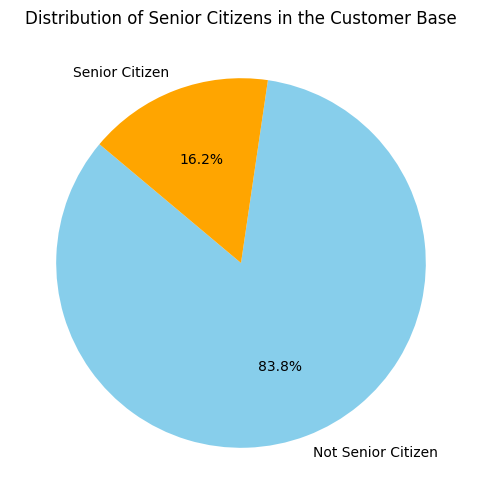

In [29]:
# Count the number of Senior and Non-Senior Citizens
senior_counts = df["SeniorCitizen"].value_counts()

# Labels for the pie chart
labels = ["Not Senior Citizen", "Senior Citizen"]

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(senior_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=["skyblue", "orange"])

# Formatting
plt.title("Distribution of Senior Citizens in the Customer Base")
plt.show()


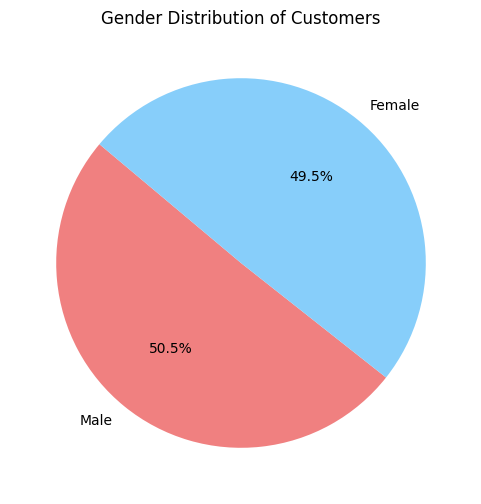

In [30]:
# Count the number of Male and Female customers
gender_counts = df["gender"].value_counts()

# Pie chart labels
labels = gender_counts.index  # ["Male", "Female"]

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=["lightcoral", "lightskyblue"])

# Formatting
plt.title("Gender Distribution of Customers")
plt.show()


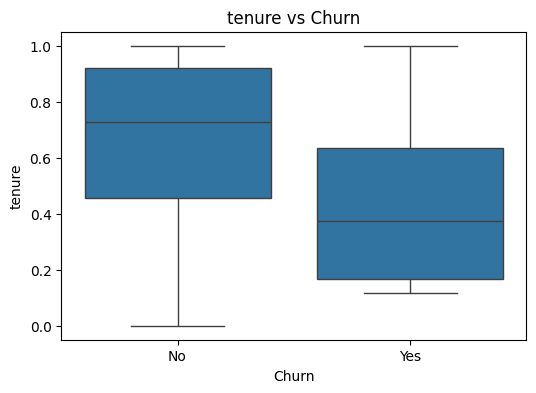

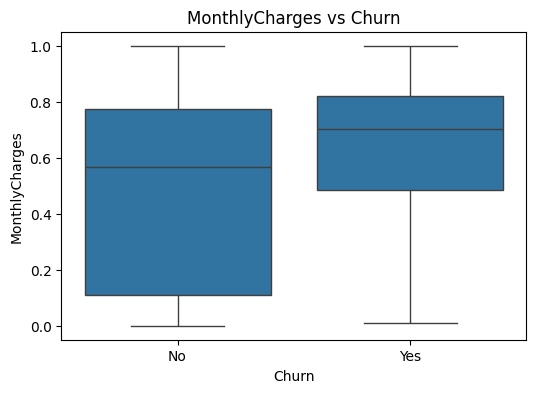

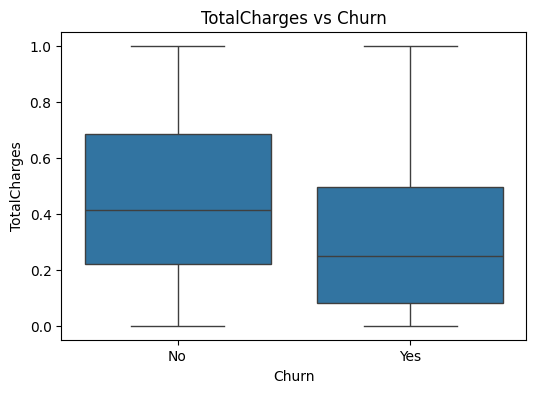

In [31]:
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="Churn", y=col, data=df)
    plt.title(f"{col} vs Churn")
    plt.show()


- customer churn is less among people who have subscribed for a longer tenure
- churn is higher for people who play higher monthly charges
- lower total charges result in overall customers leaving

In [32]:
df.head()

,customerID,gender,SeniorCitizen,tenure,PhoneService,MultipleLines,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Streaming,Support,Security-Backup,Family_Status
0,7590-VHVEG,Female,0,0.117851,No,No phone service,DSL,Month-to-month,Yes,Electronic check,0.179844,0.012690,No,None,None,Online Backup Only,"Couple, No Kids"
1,5575-GNVDE,Male,0,0.687184,Yes,No,DSL,One year,No,Mailed check,0.494249,0.440402,No,None,Device Protection Only,Online Security Only,"Single, No Kids"
2,3668-QPYBK,Male,0,0.166667,Yes,No,DSL,Month-to-month,Yes,Mailed check,0.462814,0.068241,Yes,None,None,Both,"Single, No Kids"
3,7795-CFOCW,Male,0,0.790569,No,No phone service,DSL,One year,No,Bank transfer (automatic),0.336870,0.434049,No,None,Both,Online Security Only,"Single, No Kids"
4,9237-HQITU,Female,0,0.166667,Yes,No,Fiber optic,Month-to-month,Yes,Electronic check,0.624328,0.089794,Yes,None,None,None,"Single, No Kids"


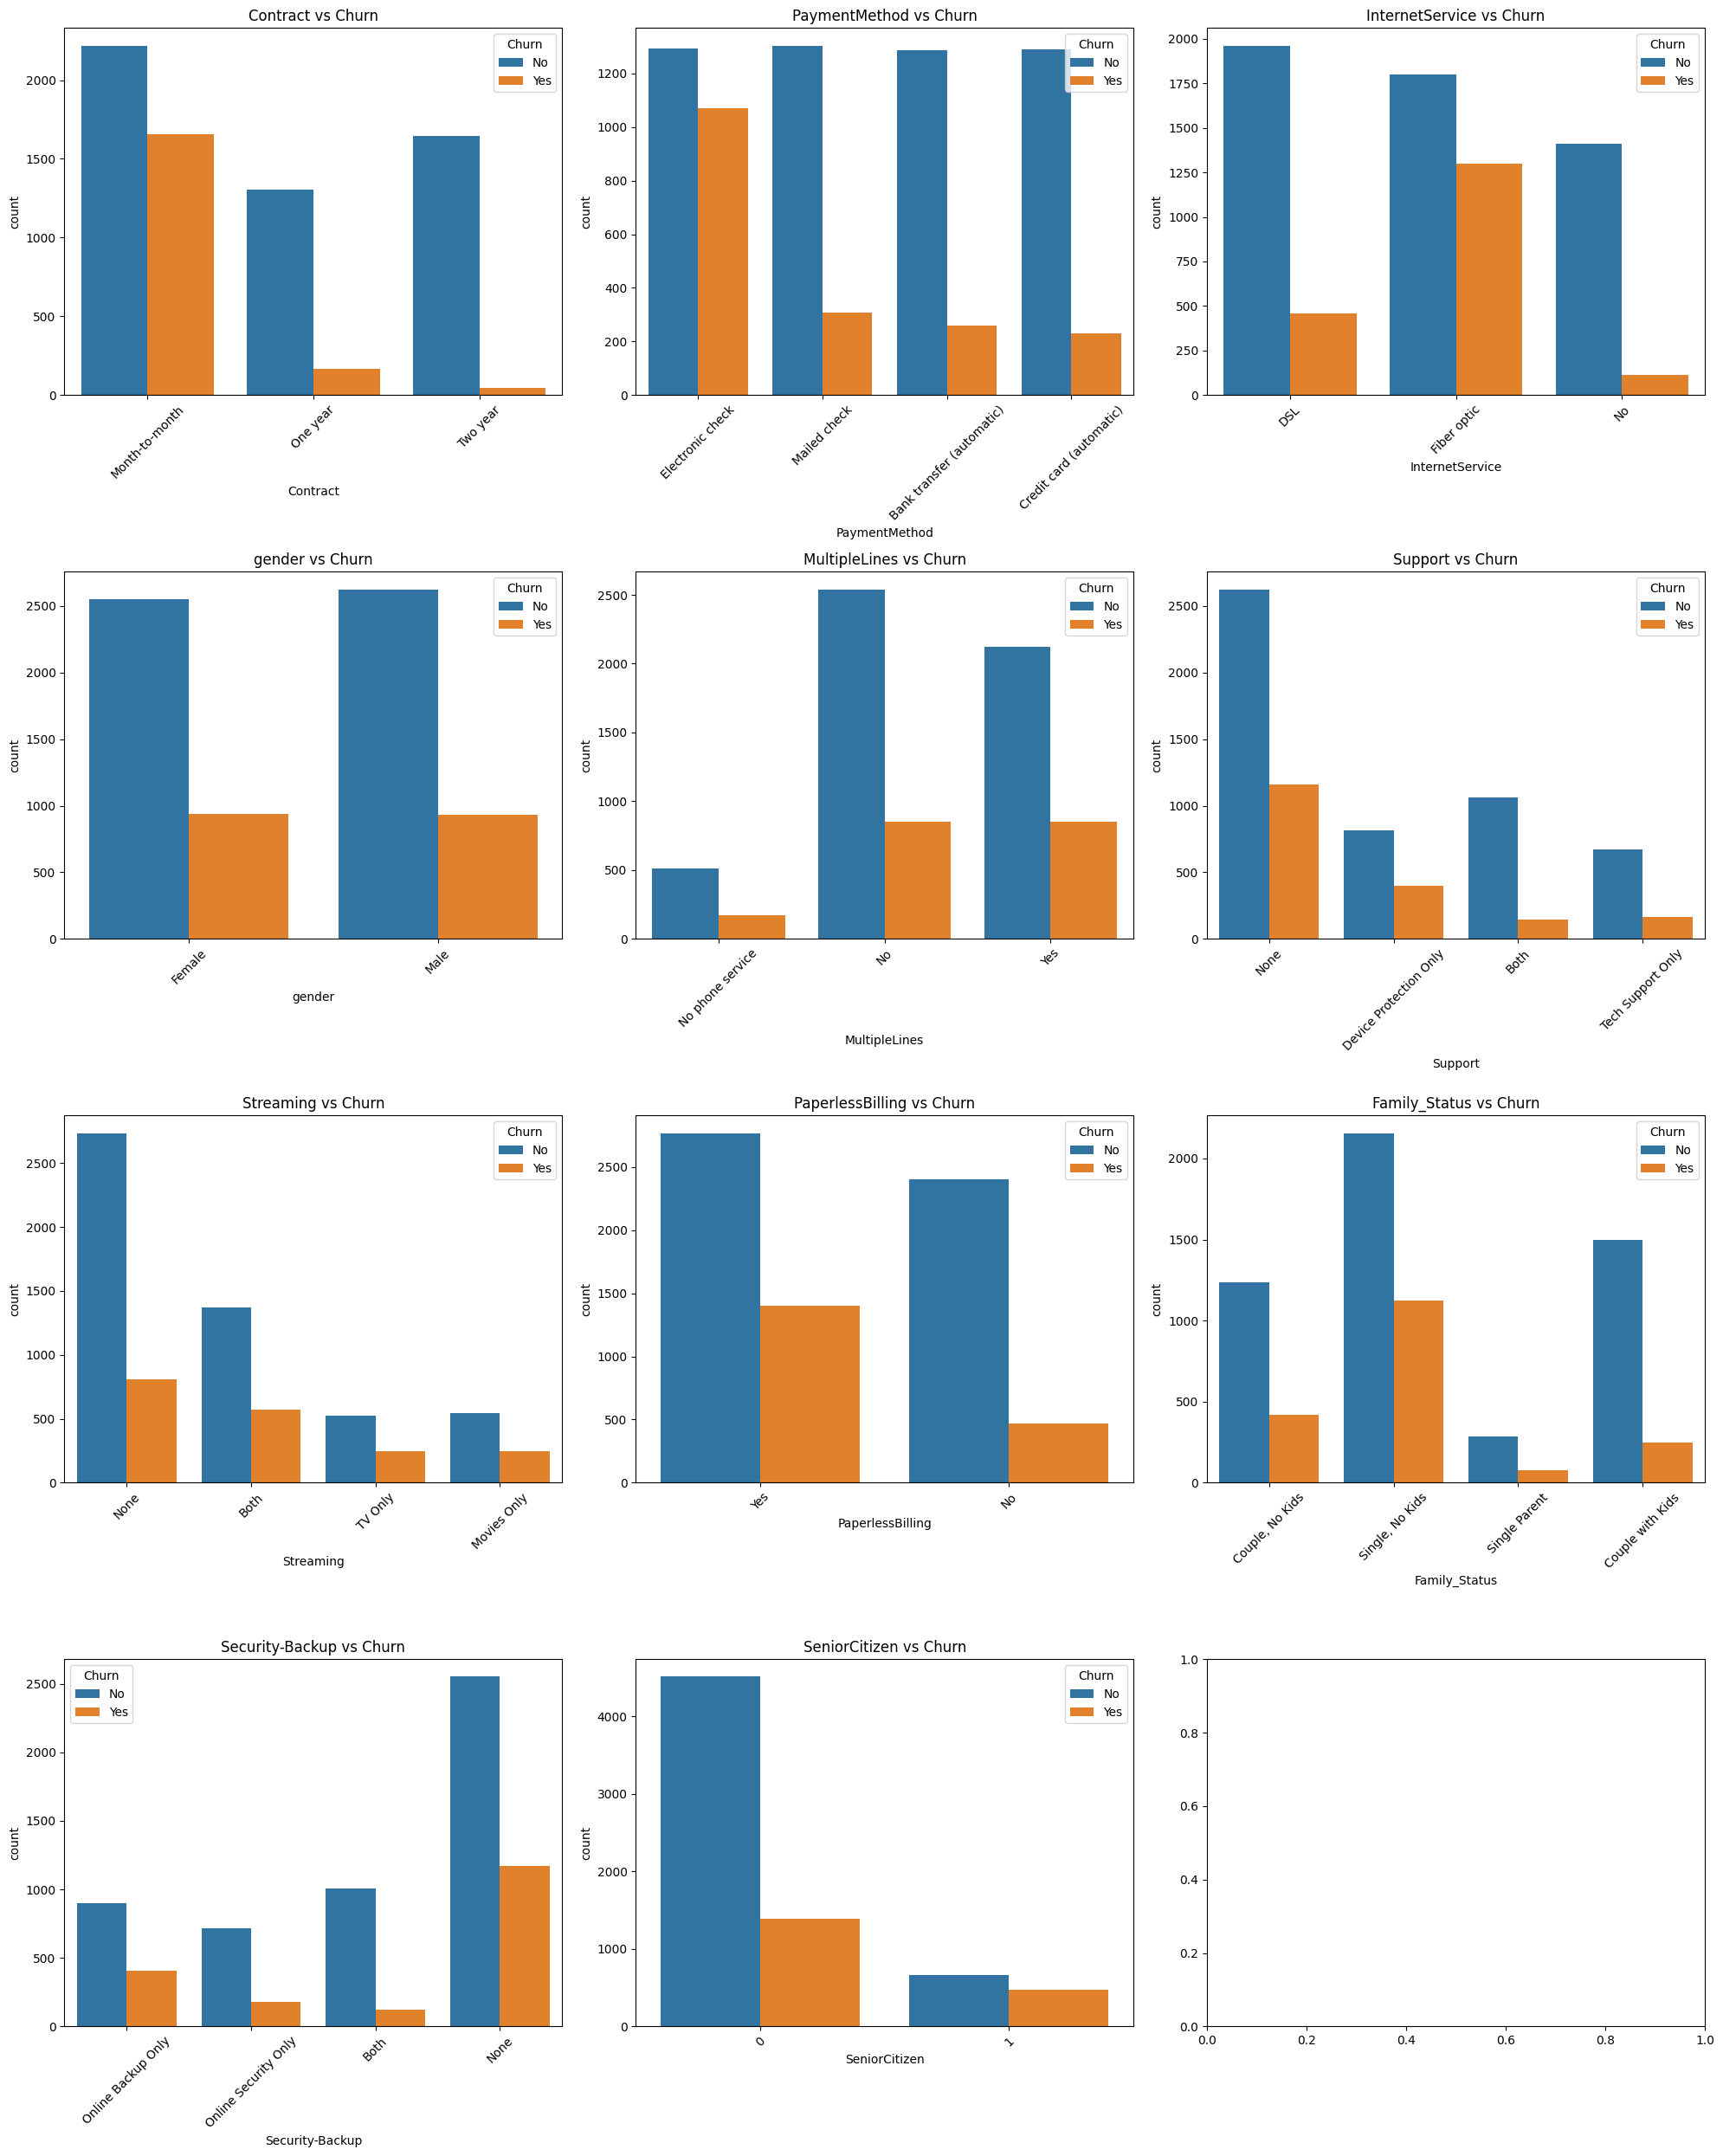

In [33]:
cat_cols = ["Contract", "PaymentMethod", "InternetService", "gender", "MultipleLines",
            "Support", "Streaming","PaperlessBilling", "Family_Status", "Security-Backup", "SeniorCitizen"]

# Creating a 4x3 grid for 11 plots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 25))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, hue="Churn", data=df, ax=axes[i])
    axes[i].set_title(f"{col} vs Churn")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


- People who pay by electric check tend to have higher churn rates.
- People without any sort of tech support have higher churn rate.
- People with no online security nor backup show higher churn rates.

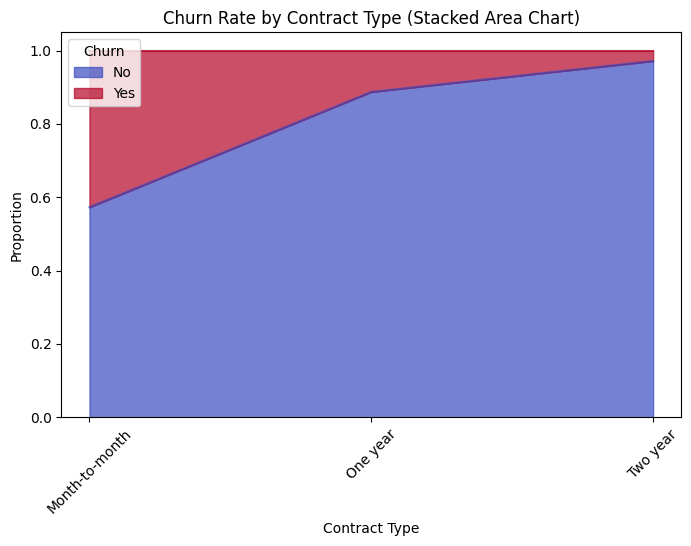

In [34]:
# Count churn for each contract type
contract_churn = df.groupby(["Contract", "Churn"]).size().unstack()

# Normalize to get proportions
contract_churn = contract_churn.div(contract_churn.sum(axis=1), axis=0)

# Plot stacked area chart
fig, ax = plt.subplots(figsize=(8, 5))
contract_churn.plot(kind='area', stacked=True, colormap="coolwarm", alpha=0.7, ax=ax)

# Formatting
plt.title("Churn Rate by Contract Type (Stacked Area Chart)")
plt.xlabel("Contract Type")
plt.ylabel("Proportion")
plt.xticks(range(len(contract_churn)), contract_churn.index, rotation=45)
plt.legend(title="Churn", loc="upper left")
plt.show()

We see that the probability of churn is more for month-to-month contracts as compared to one year or 2 year contracts

<ipython-input-35-247c333630b4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="InternetService", y=df["Churn"].apply(lambda x: 1 if x == "Yes" else 0), data=df, inner="quartile", palette="coolwarm")


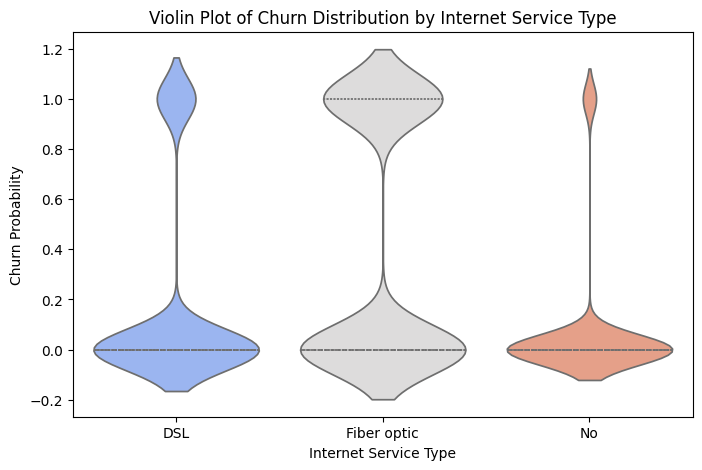

In [35]:
# Set plot style
plt.figure(figsize=(8, 5))
sns.violinplot(x="InternetService", y=df["Churn"].apply(lambda x: 1 if x == "Yes" else 0), data=df, inner="quartile", palette="coolwarm")

# Formatting
plt.title("Violin Plot of Churn Distribution by Internet Service Type")
plt.xlabel("Internet Service Type")
plt.ylabel("Churn Probability")
plt.show()

Churn rate is higher for people who have subscribed to fiber optic type of internet service as compared to DSL or even no service.

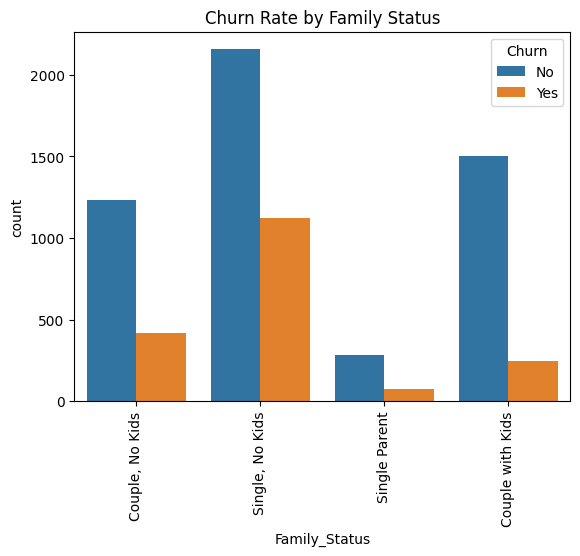

In [36]:
# Plot Churn vs New Feature
sns.countplot(x="Family_Status", hue="Churn", data=df)
plt.xticks(rotation=90)
plt.title("Churn Rate by Family Status")
plt.show()

Churn rate is higher among people who are single with no kids.

In [37]:
# Encoding categorical variables
categorical_columns = ["Contract", "PaymentMethod", "InternetService", "gender", "MultipleLines",
            "Support", "Streaming","PaperlessBilling", "Family_Status", "Security-Backup", "SeniorCitizen","PhoneService"]

for col in categorical_columns:
    df[col], _ = pd.factorize(df[col])

df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

In [38]:
# Move "Churn" to the last column
df = df[[col for col in df.columns if col != "Churn"] + ["Churn"]]

In [39]:
# Detecting and handling missing values that arose during the encoding process

missing_values = df.isnull().sum()
print(missing_values)

customerID           0
gender               0
SeniorCitizen        0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Streaming            0
Support              0
Security-Backup      0
Family_Status        0
Churn                0
dtype: int64


In [40]:
df = df.dropna(subset=["TotalCharges"])

In [41]:
df.head()

,customerID,gender,SeniorCitizen,tenure,PhoneService,MultipleLines,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Streaming,Support,Security-Backup,Family_Status,Churn
0,7590-VHVEG,0,0,0.117851,0,0,0,0,0,0,0.179844,0.012690,0,0,0,0,0
1,5575-GNVDE,1,0,0.687184,1,1,0,1,1,1,0.494249,0.440402,0,1,1,1,0
2,3668-QPYBK,1,0,0.166667,1,1,0,0,0,1,0.462814,0.068241,0,0,2,1,1
3,7795-CFOCW,1,0,0.790569,0,0,0,1,1,2,0.336870,0.434049,0,2,1,1,0
4,9237-HQITU,0,0,0.166667,1,1,1,0,0,0,0.624328,0.089794,0,0,3,1,1


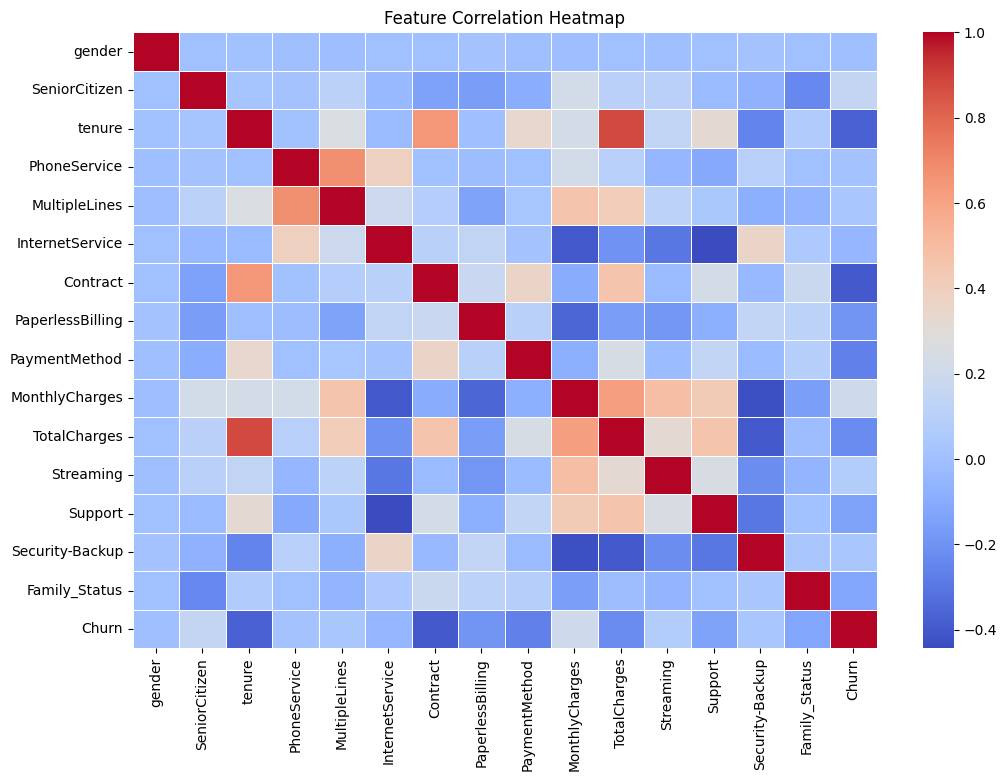

In [42]:
# Compute the correlation matrix
correlation_matrix = df.drop(columns=["customerID"]).corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


Absolute Correlation of Churn is highest with Contract, tenure and payment method

### Training a Logistic Regression model

Accuracy: 0.8017057569296375
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.66      0.52      0.58       374

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.73      1407
weighted avg       0.79      0.80      0.79      1407

Confusion Matrix:
 [[932 101]
 [178 196]]


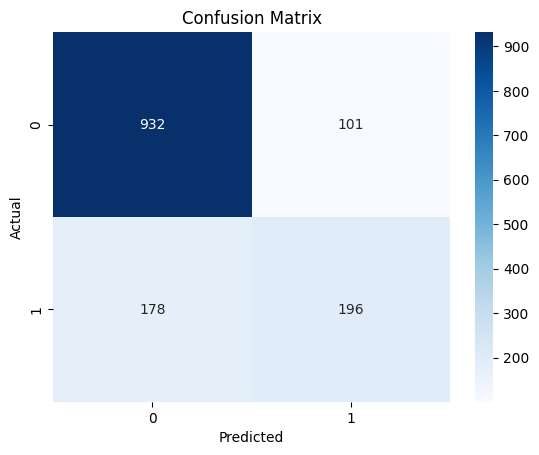

In [43]:
# Define features (X) and target variable (y)
X = df.drop(columns=["Churn","customerID"])
y = df["Churn"]

# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit the model
logreg = LogisticRegression(random_state=42)

logreg.fit(X_train, y_train)

# Make predictions using the best model
y_pred = logreg.predict(X_test)

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


hyperparameter tuning doesnt produce better results

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.8017057569296375
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.66      0.52      0.58       374

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.73      1407
weighted avg       0.79      0.80      0.79      1407

Confusion Matrix:
 [[932 101]
 [178 196]]


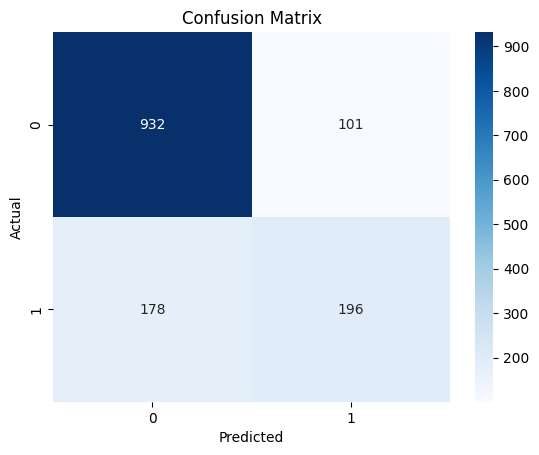

In [44]:
# Define hyperparameter grid
param_grid = {
    "C": [0.001, 0.01, 0.1, 1,10, 100],  # Regularization strength
    "penalty": ["l1", "l2"],  # Type of regularization
    "solver": ["liblinear", "saga"]  # Solvers that support L1/L2 penalty
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,  # 5-Fold Cross Validation
    n_jobs=-1,  # Use all CPU cores
    verbose=1
)

# Fit the model with Grid Search
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred = logreg.predict(X_test)

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


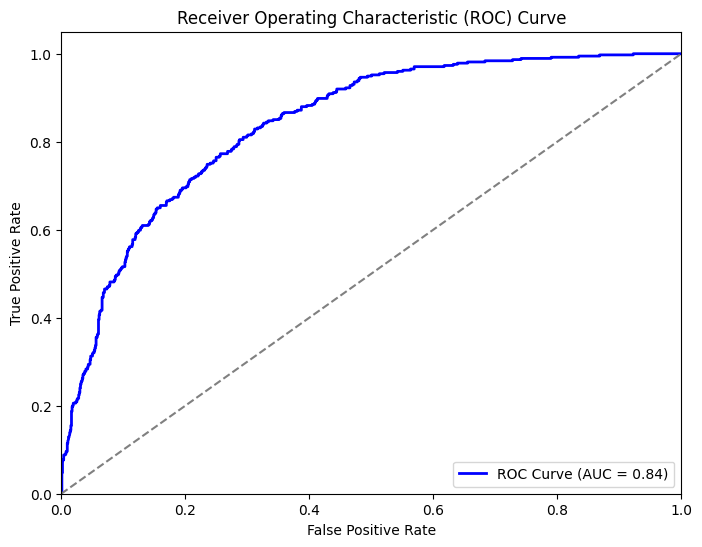

In [45]:
# Get predicted probabilities for positive class (1)
y_probs = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)  # Compute AUC score

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [46]:
# Extract feature importance (coefficients)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': best_model.coef_[0]})

# Sort by absolute coefficient value (strongest predictors)
feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Display top features
print(feature_importance[['Feature', 'Coefficient']])


             Feature  Coefficient
2             tenure    -4.415290
9     MonthlyCharges     2.996081
10      TotalCharges     1.682609
3       PhoneService    -1.667200
6           Contract    -0.840703
7   PaperlessBilling    -0.360146
4      MultipleLines     0.279641
1      SeniorCitizen     0.242632
5    InternetService     0.219152
12           Support    -0.196803
8      PaymentMethod    -0.131977
13   Security-Backup     0.107391
14     Family_Status    -0.083631
11         Streaming    -0.049200
0             gender    -0.017481


Features ranked by importance are Tenure, Monthly and Total Charges.

### Training a KNN model

🔹 Accuracy: 0.7569296375266524

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.84      1033
           1       0.54      0.52      0.53       374

    accuracy                           0.76      1407
   macro avg       0.69      0.68      0.68      1407
weighted avg       0.75      0.76      0.76      1407


🔹 Confusion Matrix:
 [[869 164]
 [178 196]]


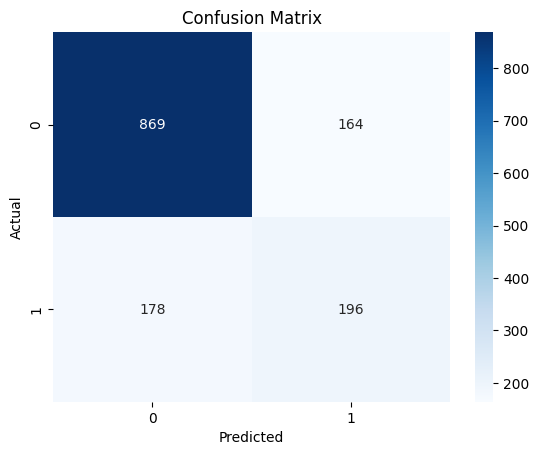

In [47]:
warnings.filterwarnings("ignore")

# Define features (X) and target (y)
X = df.drop(columns=["Churn","customerID"])
y = df["Churn"]

# Split dataset into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train.iloc[:, :] = scaler.fit_transform(X_train)
X_test.iloc[:, :] = scaler.transform(X_test)

# Train KNN model (using k=5 neighbors)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Evaluate model performance
print("🔹 Accuracy:", accuracy_score(y_test, y_pred))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Training a Naive Bayes model

🔹 Accuracy: 0.7505330490405118

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.76      0.82      1033
           1       0.52      0.73      0.61       374

    accuracy                           0.75      1407
   macro avg       0.70      0.74      0.71      1407
weighted avg       0.79      0.75      0.76      1407


🔹 Confusion Matrix:
 [[784 249]
 [102 272]]


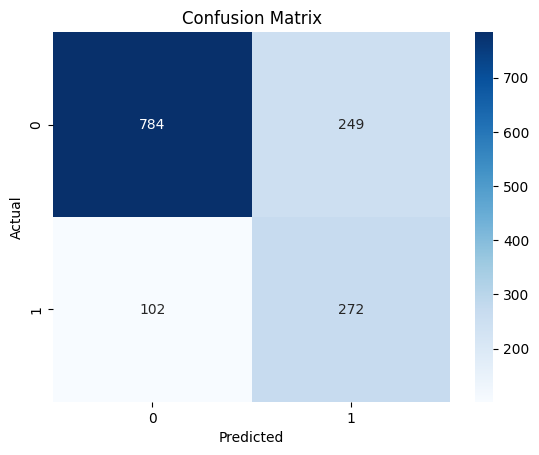

In [48]:
warnings.filterwarnings("ignore")

# Define features (X) and target variable (y)
X = df.drop(columns=["Churn","customerID"])
y = df["Churn"]

# Split dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train.iloc[:, :] = scaler.fit_transform(X_train)
X_test.iloc[:, :] = scaler.transform(X_test)

# Train Naïve Bayes classifier
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Make predictions
y_pred = nb_model.predict(X_test)

# Evaluate model performance
print("🔹 Accuracy:", accuracy_score(y_test, y_pred))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Training a Decision Tree Model

🔹 Accuracy: 0.7739872068230277

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85      1033
           1       0.58      0.53      0.56       374

    accuracy                           0.77      1407
   macro avg       0.71      0.70      0.70      1407
weighted avg       0.77      0.77      0.77      1407


🔹 Confusion Matrix:
 [[890 143]
 [175 199]]


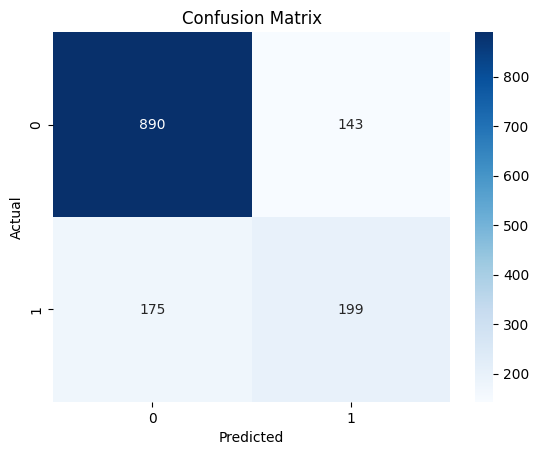

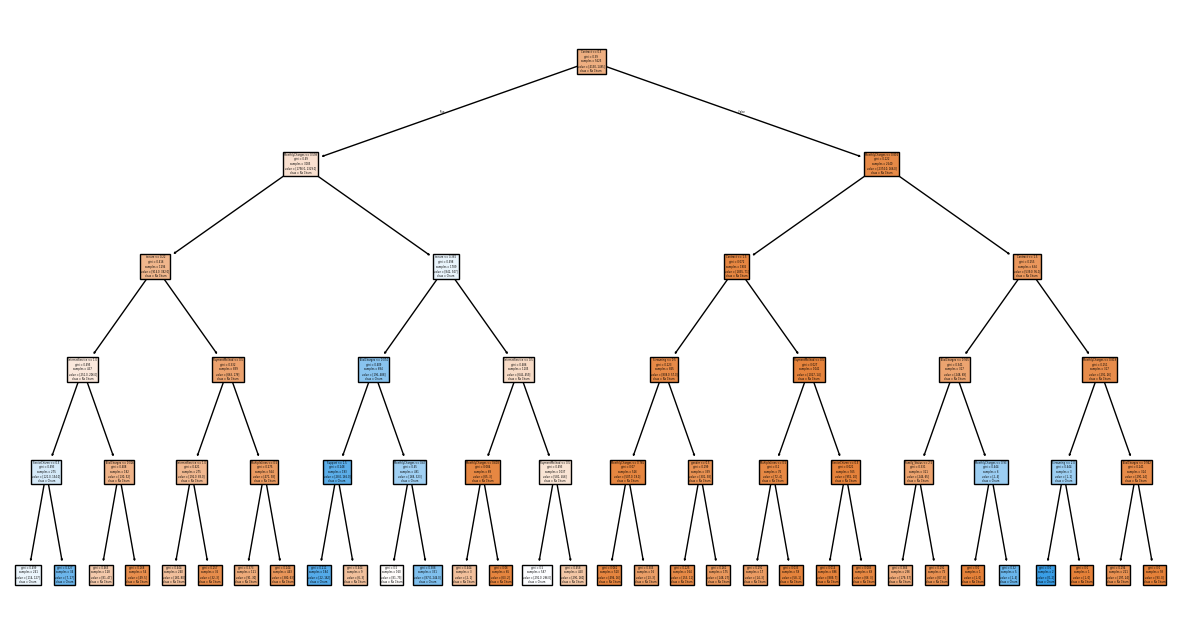

In [49]:
# Define features (X) and target variable (y)
X = df.drop(columns=["Churn","customerID"])
y = df["Churn"]

# Split dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Decision Tree model
dt_model = DecisionTreeClassifier(criterion="gini", max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions
y_pred = dt_model.predict(X_test)

# Evaluate model performance
print("🔹 Accuracy:", accuracy_score(y_test, y_pred))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot Decision Tree
plt.figure(figsize=(15, 8))
tree.plot_tree(dt_model, feature_names=X.columns, class_names=["No Churn", "Churn"], filled=True)
plt.show()


### Training a Random Forest model

🔹 Accuracy: 0.7668798862828714

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.78      0.83      1033
           1       0.55      0.72      0.62       374

    accuracy                           0.77      1407
   macro avg       0.72      0.75      0.73      1407
weighted avg       0.80      0.77      0.78      1407


🔹 Confusion Matrix:
 [[809 224]
 [104 270]]


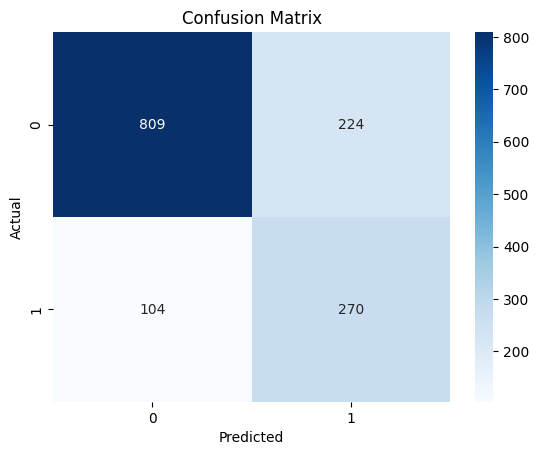

In [50]:
warnings.filterwarnings("ignore")

# Define features (X) and target variable (y)
X = df.drop(columns=["Churn","customerID"])
y = df["Churn"]

# Split dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train.iloc[:, :] = scaler.fit_transform(X_train)
X_test.iloc[:, :] = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model performance
print("🔹 Accuracy:", accuracy_score(y_test, y_pred))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


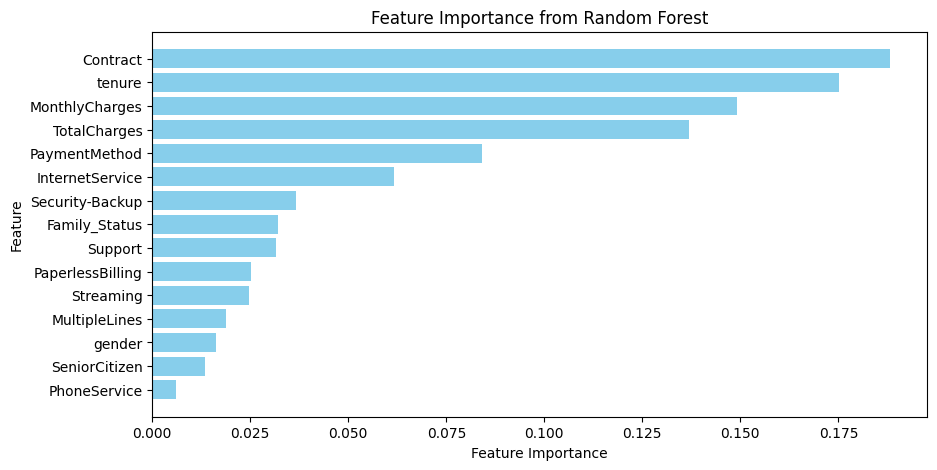

In [51]:
# Get feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})

# Sort by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10,5))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance from Random Forest")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

Features ranked by importance are contract, tenure and monthly charges.